In [1]:
import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt

from lib import data, models

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
sample_data = data.generate_ar5_data(
    100,
    [0.5, 0.2, -0.1, 0.05, 0.02],
    10,
)

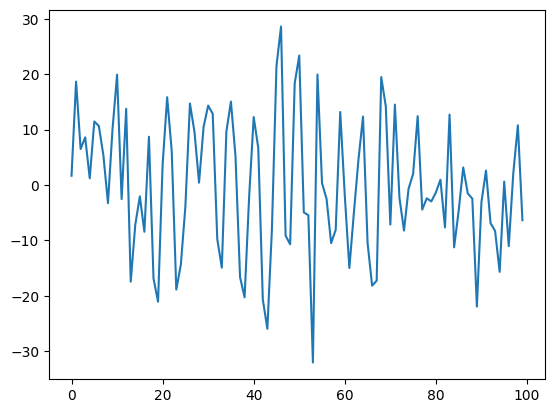

In [4]:
# Plot the data with time
time = [i for i in range(len(sample_data))]
plt.plot(time, sample_data)

In [5]:
n_chains = 5
priors = {"coefs": {"distribution": "uniform", "lower": -1, "upper": 1}, "sigma": 0.1}
n_steps = -1
data_len = len(sample_data)

In [6]:
sample_model = models.create_ar_model(
    n_chains,
    priors,
    n_steps,
    data_len,
)

/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/pymc/distributions/timeseries.py:619: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(


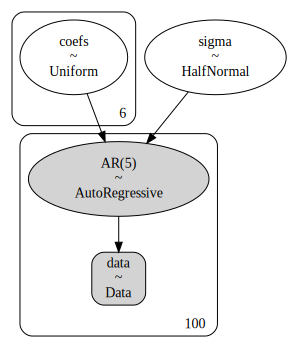

In [7]:
import pymc as pm

pm.model_to_graphviz(sample_model)

In [8]:
print(sample_model.named_vars.keys())

dict_keys(['coefs', 'sigma', 'data', 'AR(5)'])


In [9]:
with sample_model:
    # データをモデルに追加
    pm.set_data({"data": sample_data})

    # MCMCサンプリングの実行
    trace = pm.sample(draws=2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma]


/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


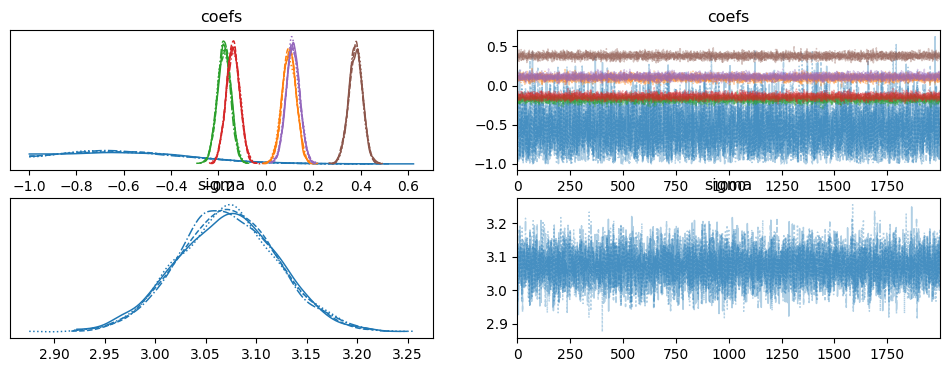

In [10]:
import arviz as az

az.plot_trace(trace)
plt.show()

In [11]:
# 事後分布の要約
summary = az.summary(trace)
print(summary)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
coefs[0] -0.576  0.257  -1.000   -0.147      0.003    0.003    5926.0   
coefs[1]  0.098  0.029   0.044    0.153      0.000    0.000    8825.0   
coefs[2] -0.176  0.029  -0.231   -0.123      0.000    0.000    8829.0   
coefs[3] -0.139  0.029  -0.195   -0.087      0.000    0.000    8759.0   
coefs[4]  0.114  0.028   0.061    0.167      0.000    0.000    7790.0   
coefs[5]  0.379  0.029   0.321    0.430      0.000    0.000    9125.0   
sigma     3.072  0.049   2.984    3.169      0.000    0.000   10030.0   

          ess_tail  r_hat  
coefs[0]    3165.0    1.0  
coefs[1]    6371.0    1.0  
coefs[2]    6409.0    1.0  
coefs[3]    6115.0    1.0  
coefs[4]    6224.0    1.0  
coefs[5]    6863.0    1.0  
sigma       5926.0    1.0  


In [12]:
# 事後予測サンプルの生成
with sample_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# InferenceDataオブジェクトの作成
idata = az.convert_to_inference_data(trace)

Sampling: [AR(5)]


/home/hope/workspace/time-series-information-criterion/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [13]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [14]:
posterior_predictive

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [15]:
print(idata.posterior.data_vars.keys())
print(idata.observed_data.data_vars.keys())
print(posterior_predictive.posterior_predictive.data_vars.keys())

KeysView(Data variables:
    coefs    (chain, draw, coefs_dim_0) float64 384kB -0.9015 0.05861 ... 0.3617
    sigma    (chain, draw) float64 64kB 3.042 3.14 3.118 ... 3.049 3.106 3.056)
KeysView(Data variables:
    AR(5)    (AR(5)_dim_0) float64 800B 1.665 18.65 6.488 ... 2.186 10.77 -6.354)
KeysView(Data variables:
    AR(5)    (chain, draw, AR(5)_dim_2) float64 6MB 61.86 71.76 ... 0.8763)


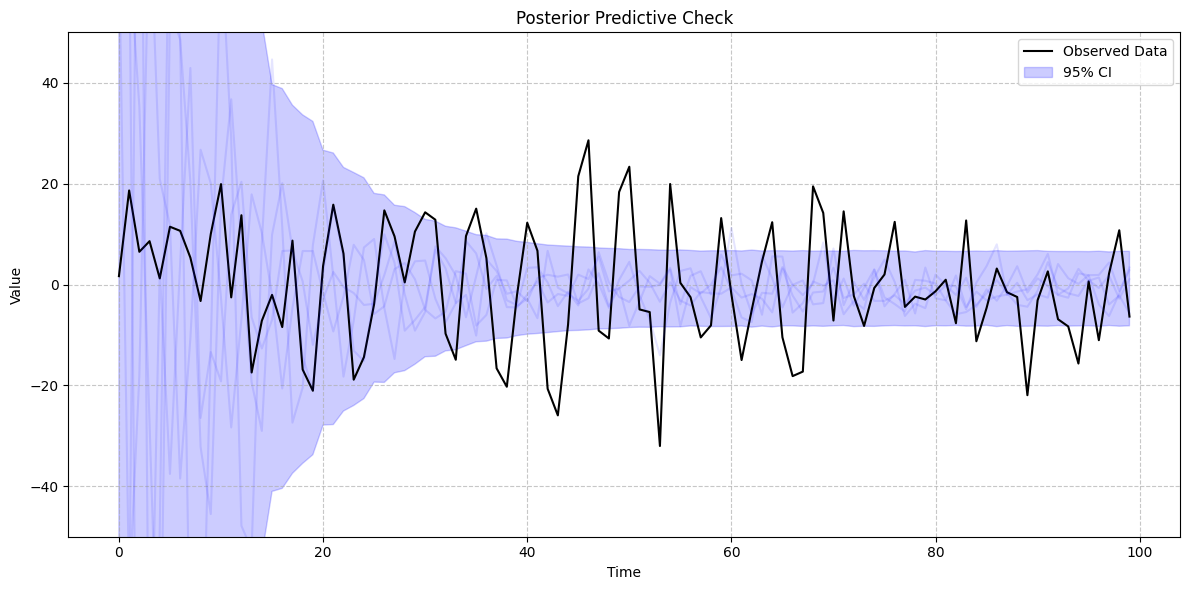

In [17]:
import numpy as np

# 予測分布のプロット
fig, ax = plt.subplots(figsize=(12, 6))

# 実際のデータをプロット
observed_data = posterior_predictive.observed_data[f'AR({n_chains})'].values
time = np.arange(len(observed_data))
ax.plot(time, observed_data, color='black', label='Observed Data')

# 予測分布をプロット
y_pred = posterior_predictive.posterior_predictive[f'AR({n_chains})'].values
num_samples = min(100, y_pred.shape[0])  # 最大100サンプルをプロット

for i in range(num_samples):
    ax.plot(time, y_pred[i, 0, :], color='blue', alpha=0.1)

# 95% 信頼区間をプロット
y_mean = np.mean(y_pred, axis=(0, 1))
y_std = np.std(y_pred, axis=(0, 1))
ax.fill_between(time, y_mean - 1.96 * y_std, y_mean + 1.96 * y_std, color='blue', alpha=0.2, label='95% CI')

# y軸の範囲を±50に設定
plt.ylim(-50, 50)

# プロットの設定
ax.set_title('Posterior Predictive Check')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()

# グリッドの追加
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
coefs[0] -0.576  0.257  -1.000   -0.147      0.003    0.003    5926.0   
coefs[1]  0.098  0.029   0.044    0.153      0.000    0.000    8825.0   
coefs[2] -0.176  0.029  -0.231   -0.123      0.000    0.000    8829.0   
coefs[3] -0.139  0.029  -0.195   -0.087      0.000    0.000    8759.0   
coefs[4]  0.114  0.028   0.061    0.167      0.000    0.000    7790.0   
coefs[5]  0.379  0.029   0.321    0.430      0.000    0.000    9125.0   
sigma     3.072  0.049   2.984    3.169      0.000    0.000   10030.0   

          ess_tail  r_hat  
coefs[0]    3165.0    1.0  
coefs[1]    6371.0    1.0  
coefs[2]    6409.0    1.0  
coefs[3]    6115.0    1.0  
coefs[4]    6224.0    1.0  
coefs[5]    6863.0    1.0  
sigma       5926.0    1.0  


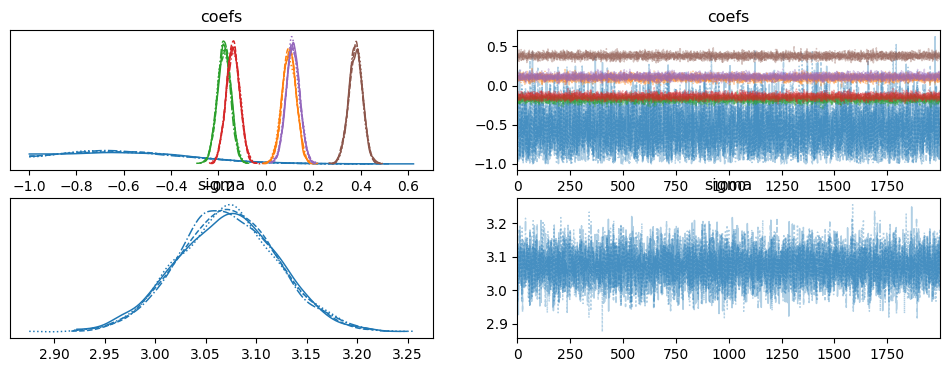

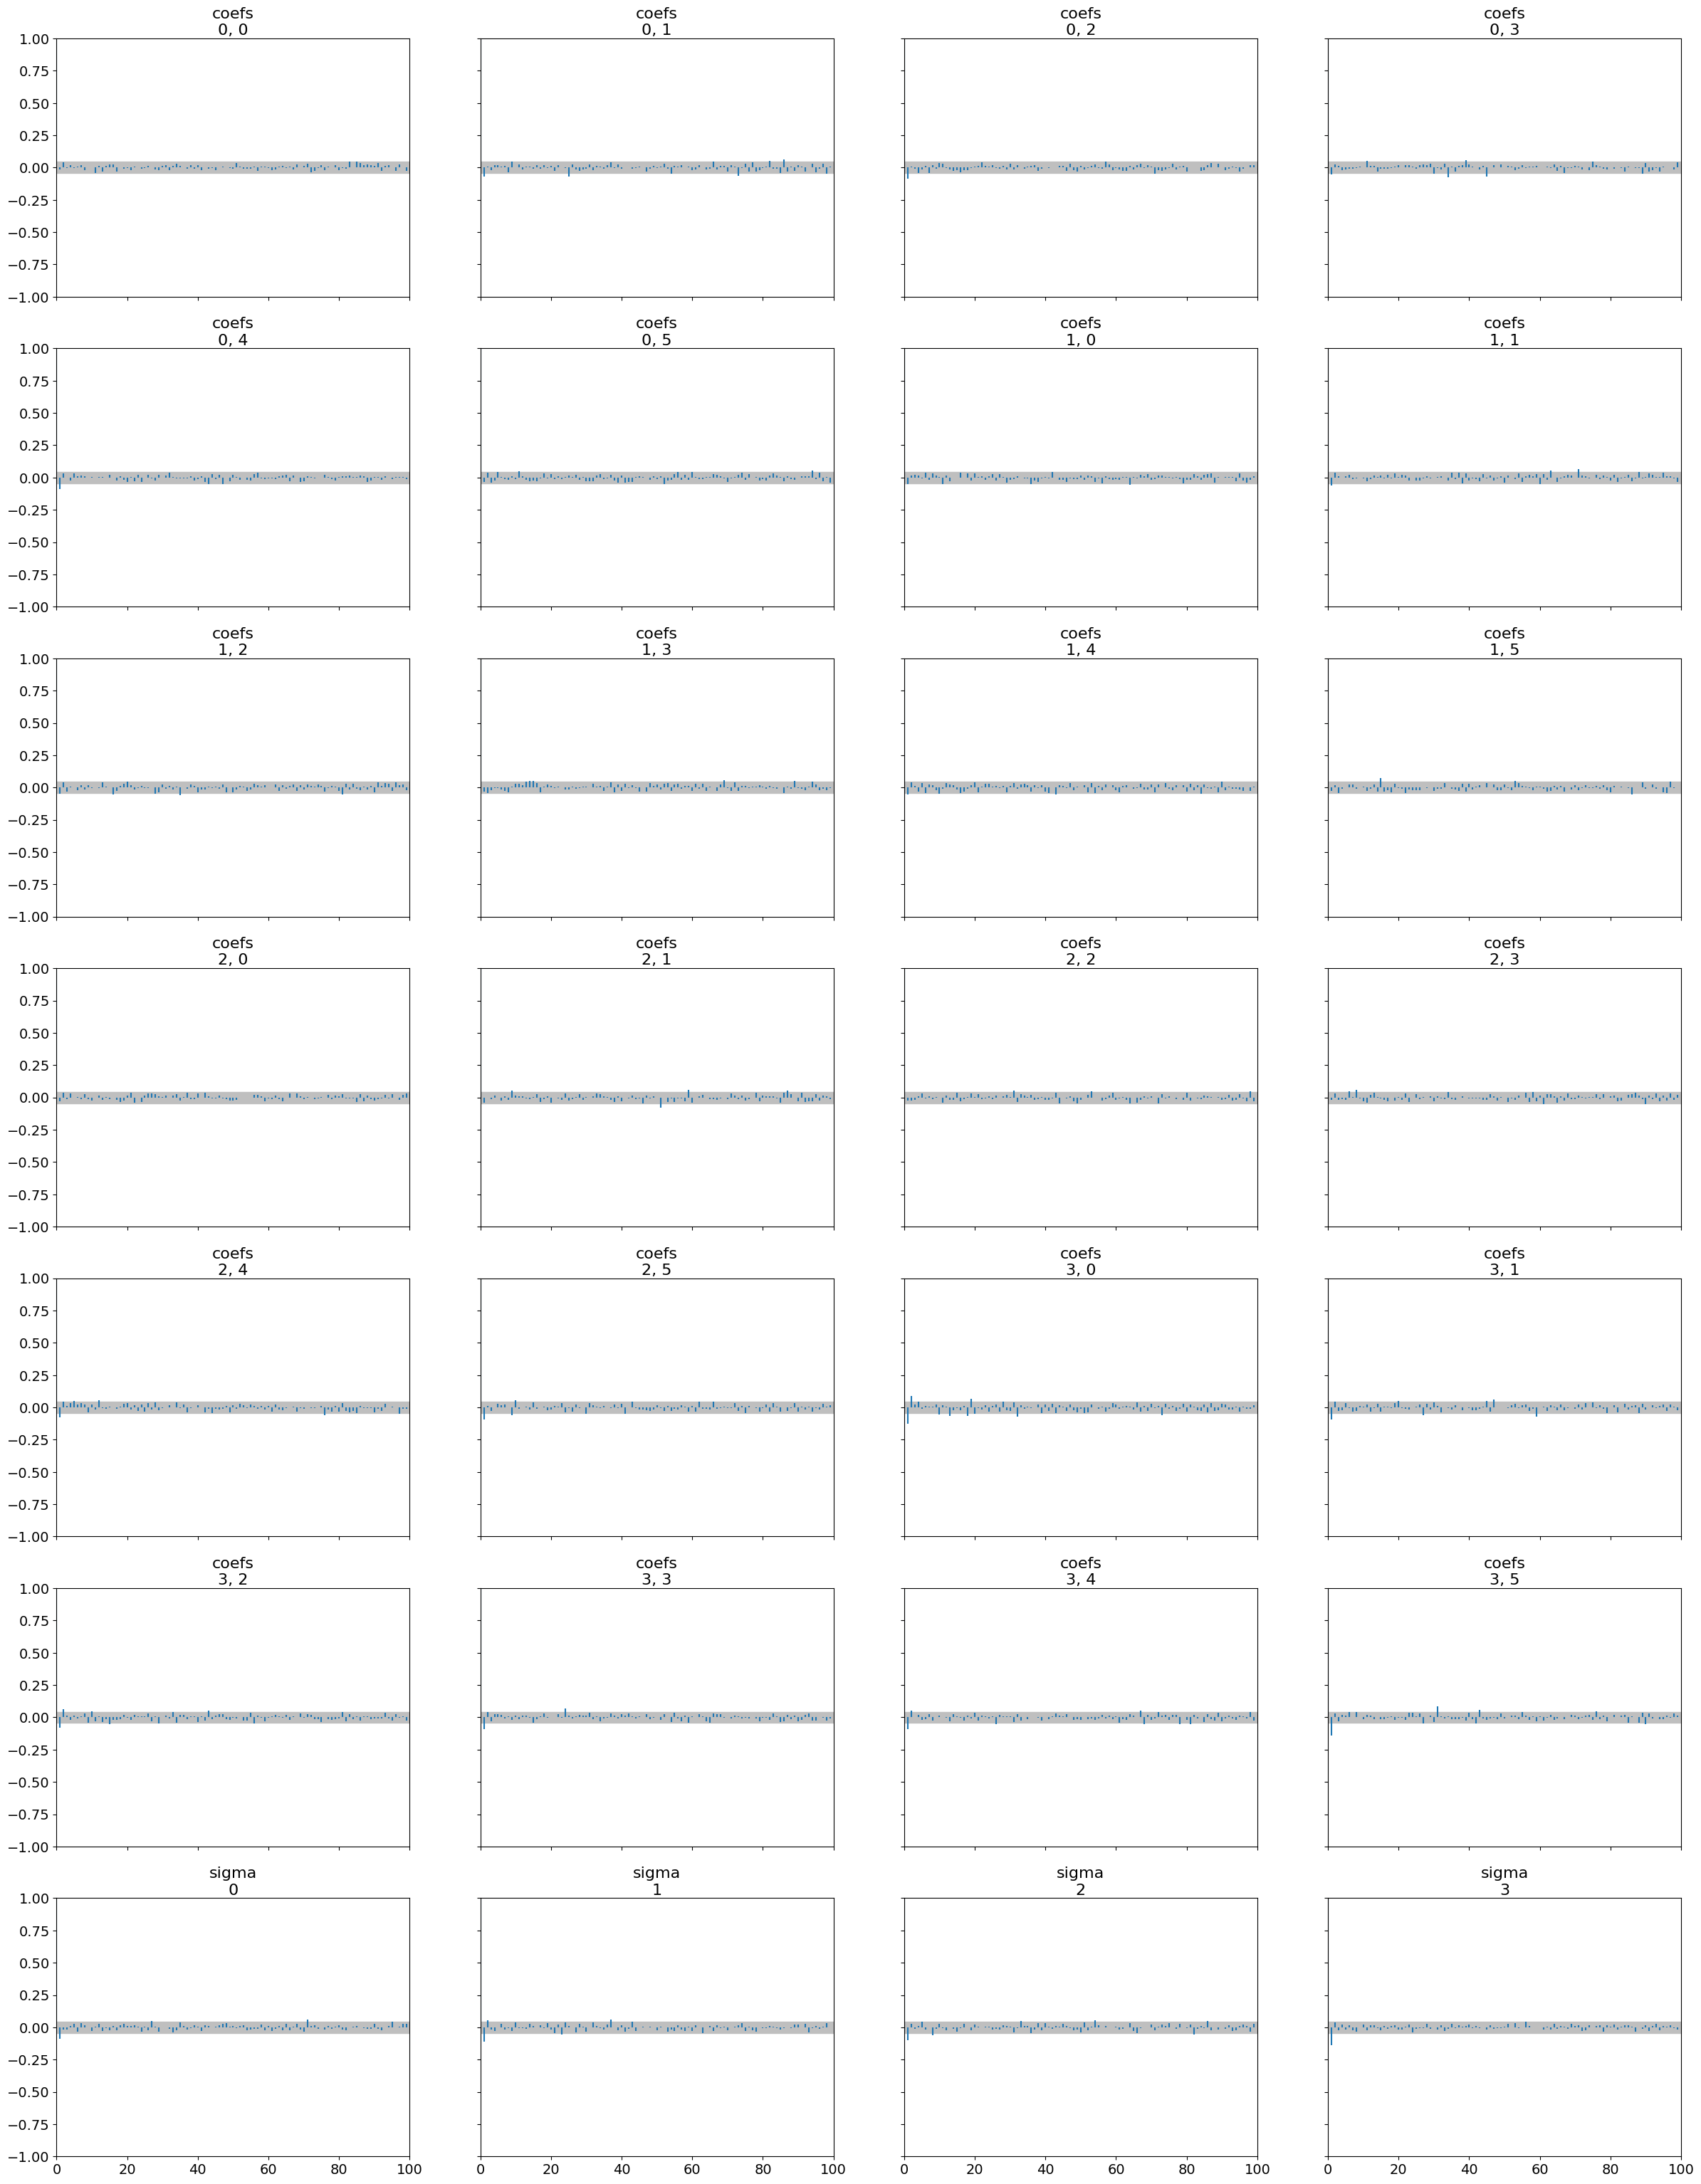

In [18]:

# 予測分布の要約統計量
summary = az.summary(idata, var_names=['coefs', 'sigma'])
print(summary)

# トレースプロット
az.plot_trace(idata, var_names=['coefs', 'sigma'])
plt.show()

# 自己相関プロット
az.plot_autocorr(idata, var_names=['coefs', 'sigma'])
plt.show()